In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# CAMEROON: ACLED Data Analysis

Conflicts in Cameroon from January 2010 through July 2021 compiled by ACLED.

## Conflict Mapping

This first section displays ACLED data in mapped form. An interactive version of these graphs and maps can be viewed in ArcGIS.

### A Continental View of Conflict

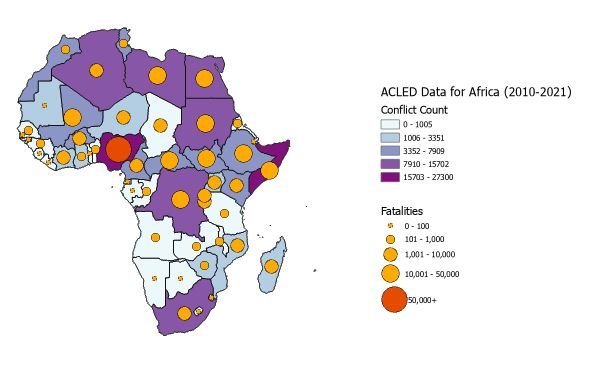

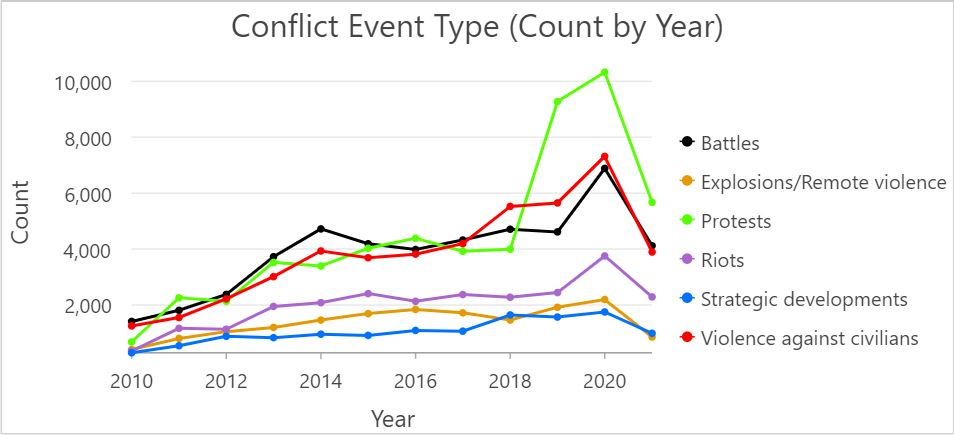

### Zooming in on Cameroon

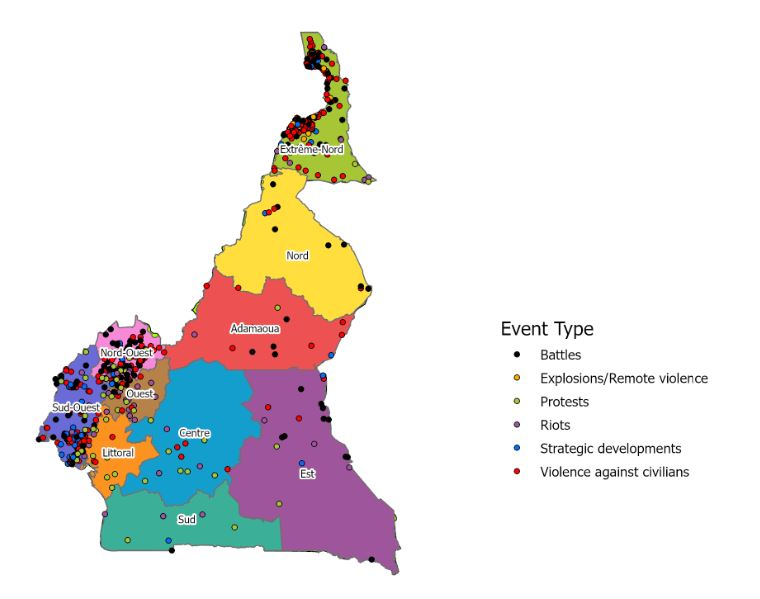

### Conflict in Cameroon by Region

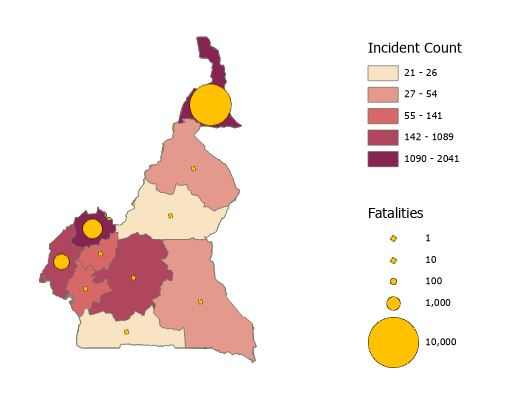

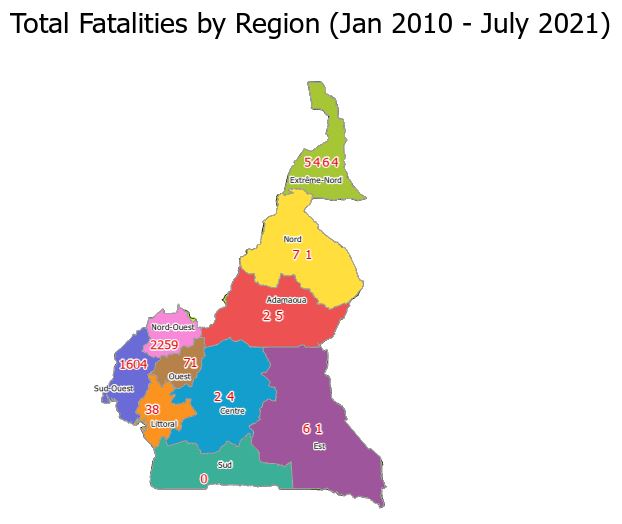

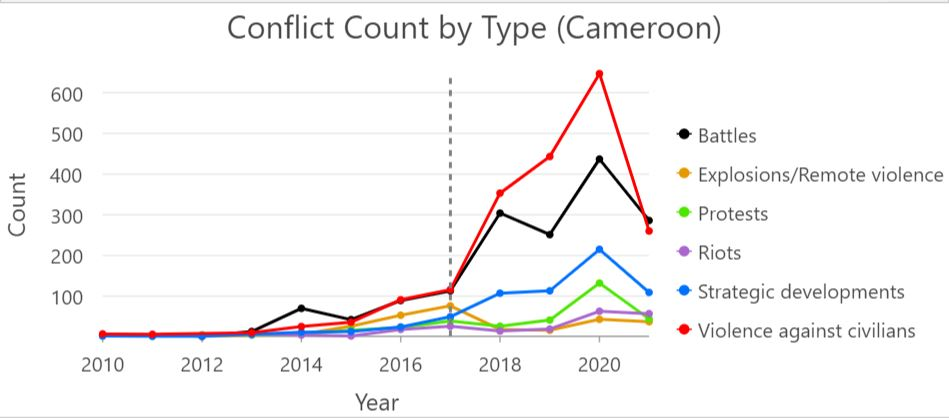

## NLP Analysis

This next section uses Natural Language Processing (NLP) to analyze ACLED's reports on each conflict incident.
Word frequency counts are presented for both the whole time period (2010-2021) and by year.

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')  # load spaCy's built-in English models
import numpy as np
import pandas as pd
import re
from collections import Counter
import plotly.express as px


In [4]:
## extract conflict notes for Cameroon
PATH = r'C:\Users\Zurdo\Documents\Rangel\Summer Internship\SI 2021\INR\Conflict'

df = pd.read_csv(PATH+r'\ACLED_Jan012010_Jul202021_selected.csv',encoding='latin-1')
## filter Cameroon 
is_cam = df['country'] == 'Cameroon'

df_cam = df[is_cam]
df_cam = df_cam.to_numpy()
#print(df_cam.shape) #5088 x 12

corpus = []
years = []
for row in df_cam:
    year = row[1]
    text = row[9]
    if type(text) == str:  #filter out 'float' type instances as will affect nlp process
        years.append(year)
        corpus.append(text)

In [5]:
#first 11 terms added after running code once
stop_words = ['size','report','protest','their','over','around','during','after','area','use','between','the','to','in','rt','of','a', 'for','and','is','on','amp','you','i','at','will','our','we','be','with','that','it','this','are','https','s','have','by','from','has','all','as','not','was','out','t','your','my','who','her','me','he','about','so','make','just','w','she','they','us','his','if','up','again','an','what','one','no','here','but','can','last','than','were','do','would','been','am','http','had','when','made','them','or','there','another','youre']


histogram = Counter()
for text in corpus:
    parsed_text = nlp(text)
    for token in parsed_text:
            lemma = token.lemma_
            lemma = lemma.lower()
            if re.match('[a-zA-Z]+$', lemma):
                histogram[lemma] += 1
                
from operator import itemgetter
sorted_lemma_count_pairs = sorted(histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

filtered_sorted_lemma_count_pairs = [(lemma, count)
                                     for lemma, count in sorted_lemma_count_pairs
                                     if lemma not in stop_words]

# for lemma, count in filtered_sorted_lemma_count_pairs[:50]:
#     print(lemma, ":", count)

In [7]:
lemmas = []
counts = []

for lemma, count in filtered_sorted_lemma_count_pairs[:10]:
    lemmas.append(lemma)
    counts.append(count)

fig = px.bar(x=lemmas, y=counts,
                 labels=dict(x="Word", y="Frequency"),title = "Cameroon Conflicts Word Freq (2010-2021)",
            width=700, height=300)
fig.update_xaxes(tickfont=dict(family='Rockwell', size=11),tickangle=45)
fig.show()

## Word Frequency by Year

Notice that "boko" and "haram" are the most common terms during 2014-2017 but by 2018 those are replaced by terms like "seperatist" and "ambazonian".

Also notice that the amount of conflict incidents in Cameroon jump significantly after 2017.

In [8]:
df = pd.read_csv(PATH+r'\ACLED_Jan012010_Jul202021_selected.csv',encoding='latin-1')
## filter Cameroon 
is_cam = df['country'] == 'Cameroon'

df_cam = df[is_cam]

#capture incident count by year
incident_count = []

year_list = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

for year in year_list:
    is_year = df_cam['year'] == year
    df_year = df_cam[is_year]
    tot_incidents = len(df_year)
    incident_count.append(tot_incidents)
    df_year = df_year.to_numpy()
    corpus = []
    for row in df_year:
        text = row[9]
        if type(text) == str:  #filter out 'float' type instances as will affect nlp process
            corpus.append(text)
    histogram = Counter()
    for text in corpus:
        parsed_text = nlp(text)
        for token in parsed_text:
                lemma = token.lemma_
                lemma = lemma.lower()
                if re.match('[a-zA-Z]+$', lemma):
                    histogram[lemma] += 1

    from operator import itemgetter
    sorted_lemma_count_pairs = sorted(histogram.items(),
                                      reverse=True,
                                      key=itemgetter(1))

    filtered_sorted_lemma_count_pairs = [(lemma, count)
                                         for lemma, count in sorted_lemma_count_pairs
                                         if lemma not in stop_words]

#     for lemma, count in filtered_sorted_lemma_count_pairs[:50]:
#         print(lemma, ":", count)
    
    lemmas = []
    counts = []

    for lemma, count in filtered_sorted_lemma_count_pairs[:10]:
        lemmas.append(lemma)
        counts.append(count)
        
    fig = px.bar(x=lemmas, y=counts,
                 labels=dict(x="Word", y="Frequency"),title = "Cameroon Protests Word Freq in %d. Total incidents = %d" % (year, tot_incidents),
                 width=700, height=300)
    fig.update_xaxes(tickfont=dict(family='Rockwell', size=11),tickangle=45)
    fig.show()
    

In [12]:
fig = px.line(x=year_list[:-1], y=incident_count[:-1],
                     labels=dict(x="Year", y="Incident Count"),title = "Cameroon Conflict Incident Counts (by Year)",
             width=700, height=400)
fig.update_xaxes(tickfont=dict(family='Rockwell', size=11),tickangle=45)
fig.add_vline(x=2017,line_dash="dash", line_color="red")
fig.show()

## Topic Modeling using LDA

Topic Modeling is a Natural Language Processing (NLP) method that attempts to group words that co-occur in a corpus of text.
The output shows a range of topics numbered 0-4. It is up to the analyst to determine the meaning and significance of these topics.

In [8]:
#vocab_size = 1000
#`min_df`: ignore terms that have a document frequency strictly lower than the given threshold
#`max_df`: ignore terms that have a document frequency strictly higher than the given threshold
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=.1,
                                stop_words='english',
#                                max_features=vocab_size)
                               )
tf = tf_vectorizer.fit_transform(corpus)
#tf is 32856 (events) x 53 (words)
# tf.shape

tf= tf.toarray()


In [9]:
# list of words corresponding to each column on matrix above
print(tf_vectorizer.get_feature_names())
print(len(tf_vectorizer.get_feature_names()))

['ambazonian', 'april', 'attacked', 'bamenda', 'boko', 'casualty', 'engaged', 'extreme', 'fatality', 'february', 'fighters', 'fights', 'forces', 'haram', 'injured', 'january', 'killed', 'killing', 'march', 'mayo', 'mezam', 'military', 'nord', 'ouest', 'people', 'report', 'reported', 'sava', 'separatists', 'size', 'subdivision', 'sud', 'suspected', 'town', 'village']
35


## Fit LDA model to data

In [10]:
num_topics = 5

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics)
lda.fit(tf)

# word_topic_matrix = lda.transform(tf)

LatentDirichletAllocation(n_components=5)

In [11]:
# normalize word counts to get probability distributions
print(lda.components_.shape)
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])
print(topic_word_distributions.sum(axis=1)) #verify prob sum adds up to 1


(5, 35)
[1. 1. 1. 1. 1.]


In [12]:
num_top_words = 5

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words, tf_vectorizer)

Displaying the top 5 words per topic and their probabilities within the topic...

[Topic 0]
ambazonian : 0.12733963674658422
separatists : 0.1265008099082537
ouest : 0.12405252759080126
sud : 0.09452945138272117
subdivision : 0.0772360789524175

[Topic 1]
reported : 0.16841421171173665
fatality : 0.1346016392047597
casualty : 0.13460163890334023
military : 0.060590111159806254
forces : 0.060454996125768774

[Topic 2]
ouest : 0.0919176880252392
nord : 0.0909937528932679
ambazonian : 0.07647530362027766
military : 0.07616211207031912
forces : 0.07300717581514297

[Topic 3]
forces : 0.11178476452480497
size : 0.0981149771558575
subdivision : 0.09297988219735526
report : 0.0875548164711144
town : 0.08254870731528538

[Topic 4]
extreme : 0.11278014654811763
nord : 0.10487175207441057
haram : 0.09915041997548021
boko : 0.09915041997547266
mayo : 0.09386692326937723



In [13]:
## extract conflict notes for Cameroon
PATH = r'C:\Users\Zurdo\Documents\Rangel\Summer Internship\SI 2021\INR\Conflict'

df = pd.read_csv(PATH+r'\ACLED_Jan012010_Jul202021_selected.csv',engine = "python")
## filter Cameroon 
is_cam = df['country'] == 'Cameroon'

df_cam = df[is_cam]

print(df_cam.columns)

Index(['event_date', 'year', 'event_type', 'sub_event_type', 'actor1',
       'region', 'country', 'latitude', 'longitude', 'notes', 'fatalities',
       'iso3'],
      dtype='object')


## Top Conflict Actors in Cameroon

An analysis of individual actors listed in the ACLED data reveals a total of 90 different actors in Cameroon since 2010.

In this analysis, we'll look at the top conflict actors.

`Note:` Actor names variations were consolidated into one count: e.g. incident counts for "Islamic State (West Africa Greater Sahara Region)" and "Islamic State (West Africa Lake Chad)" were both aggregated into the same count for "Islamic State". Also, "Boko Haram" was consolidated into "Islamic State" at the request of the analyst.

In [14]:
# print(len(df_cam['actor1'].drop_duplicates()))
# print(df_cam['actor1'].drop_duplicates())
# actors = df_cam['actor1'].drop_duplicates()

#produce count of individual actors listed for Cameroon in ACLED
actors = df_cam.groupby(['actor1']).size().reset_index(name='counts')
#sort actors df by counts
actors= actors.sort_values(by=['counts'],ascending=False)

#plot actor
fig = px.bar(actors[:10], x='actor1', y='counts', title = "Top 10 Conflict Actors in Cameroon (Jan 2010 - July 2021)",
            width=700, height=400)

fig.update_xaxes(title="",tickfont=dict(family='Rockwell', size=9),tickangle=45)
fig.update_yaxes(title="Incident Count")

#shorten x axis titles
fig.update_layout(
    xaxis = {
     'tickmode': 'array',
     'tickvals': list(range(10)),
     'ticktext': actors['actor1'].str.slice(start=0,stop=35).tolist(),
    }
)


fig.show()

## try stacked barchart for actors
## do an actor count chart by year, can be animated

## Selected actors: Conflict incident count 2010-2020

The following is an animated time series showing how incident counts have changed for the time period 2010-2020 for the top conflict actors in Cameroon

In [15]:
# actors_anim = df_cam.groupby(['actor1','year']).size().reset_index(name='counts')
# #sort actors df by counts
# actors_anim= actors_anim.sort_values(by=['year','counts'],ascending=(True,False))
# actors_anim.to_csv('actors_anim.csv', index=False,encoding='utf-8')

PATH = r'C:\Users\Zurdo\Documents\Rangel\Summer Internship\SI 2021\INR\Conflict'

actors_anim_sorted = pd.read_csv(PATH+r'\actors_anim_sorted.csv',engine = 'python')


fig = px.bar(actors_anim_sorted, x="actor1",  y="counts",
                 animation_group='actor1', hover_name="actor1", #color = 'name',
                 animation_frame='year',
            width=700, height=400)
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.update_layout(
    xaxis_title=" ")
fig.update_xaxes(title="",tickfont=dict(family='Rockwell', size=9),tickangle=45)
fig.update_yaxes(title="Incident Count")
# fig.update_layout(
#     xaxis = {
#      'tickmode': 'array',
#      'tickvals': list(range(15)),
#      'ticktext': actors['actor1'].str.slice(start=0,stop=35).tolist(),
#     }
# )

fig.update_xaxes(tickangle=45)
fig.update_yaxes(range=[-10, 510])

fig.show()

### work on order 

## Conflict incident counts in 2021  (through July)

In [25]:
actors_2021 = pd.read_csv(PATH+r'\actors_2021.csv',encoding='utf-8')

fig = px.bar(actors_2021, x="actor1",  y="counts", title= "Conflict Incident Count (through July 2021)",
            width=700, height=475)
fig.update_xaxes(title="",tickfont=dict(family='Rockwell', size=12),tickangle=45)
fig.update_yaxes(title="Incident Count", range=[-10,510])
fig.update_traces(marker_color='orange')
fig.show()



## Conflict type by actor

In this section, we'll look at incident type counts by actor.

ACLED categorizes conflict incidents by both their "event" and "sub_event" type. The following two graphs show these counts respectively by actor.

In [22]:
df = pd.read_csv(PATH+r'\ACLED_Jan012010_Jul202021_selected.csv',engine='python')
is_cam = df['country'] == 'Cameroon'
df_cam = df[is_cam]

#perform incident type count by actor: by grouping 
incitype_byactor = df_cam.groupby(['event_type','actor1']).size().reset_index(name='counts')
#sort actors df by counts
incitype_byactor= incitype_byactor.sort_values(by=['counts','event_type'],ascending=False)

fig = px.bar(incitype_byactor[:25], x="actor1", y="counts", color="event_type",
             title="Incident Type Count by Actor (Jan 2010 - July 2021)",
             labels={
                 "event_type": "Event Type"
             }
            ,width=700, height=600)
                 
fig.update_xaxes(title="",tickfont=dict(family='Rockwell', size=12),tickangle=45)
fig.update_yaxes(title="Incident Count")
fig.show()

In [21]:
subevent_byactor = df_cam.groupby(['actor1','sub_event_type']).size().reset_index(name='counts')
#sort actors df by counts
subevent_byactor= subevent_byactor.sort_values(by=['counts'],ascending=False)


fig = px.bar(subevent_byactor[:30], x="actor1", y="counts", color="sub_event_type",
             title="Sub-event Type Count by Actor (Jan 2010 - July 2021)",
             color_discrete_sequence=px.colors.qualitative.Alphabet,
             labels={
                 "sub_event_type": "Sub-event Type"
             }
            ,width=700, height=600)
                 
fig.update_xaxes(title="",tickfont=dict(family='Rockwell', size=12),tickangle=45)
fig.update_yaxes(title="Incident Count")
fig.show()